```
From: https://github.com/ksatola
Version: 0.1.0
```

# Model - Performance Comparison Method

## Contents

- [Model Performance Comparison Method Description](#base)
- [Load daily data and model](#data_d)
- [Model Performance Comparison Method](#method)

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import sys
sys.path.insert(0, '../src')

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
import pandas as pd 
import numpy as np

#from pandas.plotting import lag_plot
#from pandas.plotting import autocorrelation_plot

#from statsmodels.graphics.tsaplots import plot_acf


from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from model import (
    get_pm25_data_for_modelling,
#    get_best_arima_params_for_time_series,
#    get_df_for_lags_columns
)

from measure import (
#    get_model_power,
    get_rmse
)

from plot import (
    #plot_train_test_predicted,
#    plot_observed_vs_predicted,
#    plot_observations_to_predictions_relationship,
    #fit_theoretical_dist_and_plot,
    plot_observed_vs_predicted_with_error
)

#from stats import (
#    adfuller_test
#)

---
<a id='base'></a>

## Model Performance Comparison Method Description

XXXXXX - text in Final notebook

---
<a id='data_d'></a>

## Load daily data and model

In [8]:
dfd = get_pm25_data_for_modelling('ts', 'd')
dfd.head()

common.py | 42 | get_pm25_data_for_modelling | 07-Jun-20 21:10:17 | INFO: Dataframe loaded: /Users/ksatola/Documents/git/air-polution/agh/data/dfpm25_2008-2018_daily.hdf
common.py | 43 | get_pm25_data_for_modelling | 07-Jun-20 21:10:17 | INFO: Dataframe size: (4019, 1)


,pm25
Datetime,
2008-01-01,53.586957
2008-01-02,30.958333
2008-01-03,46.104167
2008-01-04,42.979167
2008-01-05,57.312500


In [9]:
model_name = 'AR'

In [11]:
df = dfd.copy()

In [23]:
# Define first past/future cutoff point in time offset (1 year of data)
#cut_off_offset = 365*24 # for hourly data
cut_off_offset = 365 # for daily data

# Predict for X points
#n_pred_points = 24 # for hourly data
n_pred_points = 7 # for daily data

# Set datetime format for index
#dt_format = "%Y-%m-%d %H:%M:%S" # for hourly data
#dt_format = "%Y-%m-%d" # for daily data

# Set proper frequency for modelling
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
#df.index = pd.DatetimeIndex(df.index).to_period('H') # for hourly data
#df.index = pd.DatetimeIndex(df.index).to_period('D') # for daily data

### Train test split

In [14]:
# Create train / test datasets
X = df.dropna()
df_train = X[1:len(X)-cut_off_offset]
df_test = X[len(X)-cut_off_offset:]

In [15]:
df_train.shape

(3653, 1)

In [16]:
df_test.shape

(365, 1)

### Train the model

In [17]:
# Train the model / the model proposes the ideal number of lags for forecasting
model = AR(df_train)
model_fitted = model.fit()

In the above, we are simply creating a testing and training dataset and then creating and fitting our AR() model. The AR() function tries to estimate the number of lags for the prediction. Once you’ve fit the model, you can look at the chosen lag and parameters of the model using some simple print statements.

In [18]:
model_fitted

In [19]:
print(f'The lag value chose is: {model_fitted.k_ar}')

The lag value chose is: 30


In [20]:
print(f'The coefficients of the model are:\n {model_fitted.params}')

The coefficients of the model are:
 const       3.254686
L1.pm25     0.702070
L2.pm25    -0.144036
L3.pm25     0.078781
L4.pm25    -0.012828
L5.pm25     0.002850
L6.pm25     0.018810
L7.pm25     0.026406
L8.pm25     0.040924
L9.pm25     0.008997
L10.pm25   -0.038482
L11.pm25    0.040293
L12.pm25    0.076362
L13.pm25   -0.011441
L14.pm25    0.049392
L15.pm25   -0.055448
L16.pm25    0.066617
L17.pm25   -0.002334
L18.pm25   -0.003607
L19.pm25    0.056132
L20.pm25   -0.013051
L21.pm25    0.066457
L22.pm25   -0.004800
L23.pm25    0.003229
L24.pm25   -0.039893
L25.pm25    0.012186
L26.pm25    0.016868
L27.pm25   -0.036194
L28.pm25    0.018096
L29.pm25   -0.022881
L30.pm25    0.014114
dtype: float64


---
<a id='method'></a>

## The method

In [21]:
# In / Out of sample prediction (AR model)
# There will be a different function ca be different per different type of model

def predict_ar(X: list, coef: list) -> float:
    yhat = 0.0
    #print(f'coef -> {coef}')
    #print(f'X -> {X}')
    for i in range(1, len(coef)):
        # X values must be applied/indexed backwards as we travel back in the past
        yhat += coef[i] * X[-i]
        #print(coef[i], X[i], yhat)
    return yhat + coef[0]

In [120]:
# This function shows the method of different algorithms comparison
def walk_forward_model_validation(data: pd.DataFrame, 
                            col_name: str, 
                            model_params: list, 
                            cut_off_offset:int = 365, 
                            n_pred_points: int = 1, 
                            n_folds: int = -1):
    
    # Take entire dataset and splits it to train/test 
    # according to train_test_split_position using cut_off_offset
    train_test_split_position = int(len(data)-cut_off_offset)    
    max_n_folds = len(data) - train_test_split_position
    
    if n_folds < 1:
        last_n_folds_pos = len(data)
    else:
        if n_folds > max_n_folds:
            last_n_folds_pos = max_n_folds
        else:
            last_n_folds_pos = train_test_split_position + n_folds
    
    #print(range(train_test_split_position, n_folds))
    
    # A list of data frames with results from each fold n_pred_points predictions
    fold_results = []
    
    # Do this for each data point in the test part
    for i in range(train_test_split_position, last_n_folds_pos):
        
        # For each fold
        history = data[0:i].copy()
        future = data[i:i+n_pred_points].copy()
        
        #print(f'history.shape {history.shape}')
        #print(f'future.shape {future.shape}')
        #print(history.head(1))
        #print(future.head(10))
        
        predicted = []
        
        # Forecast values for n_pred_points
        for j in range(len(future)):
            
            #print(history.tail(5))
            
            # Get prediction for t+1 lag
            yhat = predict_ar(history[col_name].tail(len(model_params)+1).tolist(), model_params)
            #print(list(reversed(history[col_name].tail().tolist())))
            
            #history[col_name].tail(len(model_params)).tolist()

            # Add it as a predicted value
            predicted.append(yhat)
            #print(predicted)

            # Create a new row with the next data point index from df_test
            # Extend history with the last predicted value
            history = history.append(future[j:j+1])
            
            # Replace observed value with predicted value
            history.loc[future[j:j+1].index] = [yhat]
            
        # Summarize results for the fold
        # Each row represents next predicted lag
        df_fold_observed = future[col_name].copy() # observed
        df_fold_predicted = history[-n_pred_points:].copy() # predicted
        df_fold_results = pd.concat([df_fold_observed, df_fold_predicted], axis=1)
        df_fold_results.columns = ['observed', 'predicted']
        
        df_fold_results['error'] = np.abs(df_fold_results['observed'] - df_fold_results['predicted']) # error
        df_fold_results['abs_error'] = np.abs(df_fold_results['observed'] - df_fold_results['predicted']) # absolute error
        
        fold_results.append(df_fold_results)
        #print(df_fold_results)
    
    return fold_results

In [121]:
# Testing
fold_results = walk_forward_model_validation(data=df, 
                                         col_name='pm25', 
                                         model_params=[3.254686, 0.702070, -0.144036], 
                                         cut_off_offset=cut_off_offset, 
                                         n_pred_points=n_pred_points, 
                                         n_folds=1)

In [27]:
len(fold_results)

1

In [28]:
fold_results[0]

,observed,predicted,error,abs_error
Datetime,,,,
2018-01-02,67.991848,38.338665,29.653182,29.653182
2018-01-03,16.026950,22.536039,6.509089,6.509089
2018-01-04,14.590020,13.554415,1.035605,1.035605
2018-01-05,22.094854,9.524833,12.570021,12.570021
2018-01-06,62.504217,7.989462,54.514755,54.514755
2018-01-07,43.929804,7.491929,36.437876,36.437876
2018-01-08,22.088192,7.363774,14.724417,14.724417


In [29]:
# One point forecast - part 1

# See Train the model section above

In [30]:
type(model_fitted.params)

pandas.core.series.Series

In [129]:
# One point forecast - part 2

fold_results = walk_forward_model_validation(data=df, 
                                         col_name='pm25', 
                                         model_params=model_fitted.params[:], 
                                         cut_off_offset=cut_off_offset, 
                                         n_pred_points=n_pred_points, 
                                         n_folds=-1)
print(len(fold_results))
print(fold_results[0])

365
             observed  predicted      error  abs_error
Datetime                                              
2018-01-02  67.991848  49.379772  18.612076  18.612076
2018-01-03  16.026950  46.310684  30.283734  30.283734
2018-01-04  14.590020  42.722729  28.132708  28.132708
2018-01-05  22.094854  36.818753  14.723899  14.723899
2018-01-06  62.504217  39.552410  22.951806  22.951806
2018-01-07  43.929804  44.885109   0.955304   0.955304
2018-01-08  22.088192  47.602331  25.514139  25.514139


In [123]:
fold_results[359][:1]

,observed,predicted,error,abs_error
Datetime,,,,
2018-12-26,NaN,17.102352,NaN,NaN


---
<a id='metric'></a>

## The metric

In [135]:
# Calculate RMSE for each fold

show_n_points_of_forecast = 1

start_index = show_n_points_of_forecast - 1
end_index = show_n_points_of_forecast

rmse_for_folds = []

i = 0

# n_pred_points results from the end contain NaNs
for fold in fold_results[:len(fold_results)-n_pred_points]:
    
    i += 1
    
    rmse = get_rmse(observed=fold[start_index:end_index]['observed'], 
                    predicted=fold[start_index:end_index]['predicted'])
    rmse_for_folds.append(rmse)
    #print(f'{i:03} = {model_name} RMSE {rmse}')
    

# Calculate Mean RMSE for show_n_points_of_forecast

pd.Series(rmse_for_folds).mean()

9.407572067039105

In [136]:
def get_mean_folds_rmse_for_n_prediction_points(fold_results: list, n_pred_points: int = 1):
    # For each fold and number of prediction points calculate rmse
    # Returns a list of mean folds RMSE for n_pred_points (starting at 1)
    
    mean_rmse_for_prediction_points = []
    
    # Fo each number od prediction points
    for i in range(1, n_pred_points+1):
        
        show_n_points_of_forecast = i
        start_index = show_n_points_of_forecast - 1
        end_index = show_n_points_of_forecast
    
        rmse_for_folds = []
    
        # For each fold
        # n_pred_points results from the end contain NaNs
        for fold in fold_results[:len(fold_results)-n_pred_points]:

            rmse = get_rmse(observed=fold[start_index:end_index]['observed'], 
                            predicted=fold[start_index:end_index]['predicted'])
            rmse_for_folds.append(rmse)
            #print(f'{i:03} = {model_name} RMSE {rmse}')
            
        # Calculate average RMSE for a prediction point
        mean_rmse_for_prediction_point = pd.Series(rmse_for_folds).mean()
        mean_rmse_for_prediction_points.append(mean_rmse_for_prediction_point)

    return mean_rmse_for_prediction_points

In [137]:
%%time
# Returns a list of mean folds RMSE for n_pred_points (starting at 1)
get_mean_folds_rmse_for_n_prediction_points(fold_results=fold_results, n_pred_points=n_pred_points)

CPU times: user 2.4 s, sys: 10.9 ms, total: 2.41 s
Wall time: 2.42 s


[9.407572067039105,
 12.302882402234635,
 12.889160614525139,
 13.248969832402235,
 13.538120949720671,
 13.71186312849162,
 13.83969469273743]

---
<a id='visual'></a>

## Visual representation

In [138]:
# One point forecast - part 3

show_n_points_of_foreacst = 1

start_index = show_n_points_of_foreacst - 1
end_index = show_n_points_of_foreacst

observed = pd.Series()
predicted = pd.Series()
error = pd.Series()

# n_pred_points results from the end contain NaNs
for fold in fold_results[:len(fold_results)-n_pred_points]:
    observed = observed.append(fold[start_index:end_index]['observed'])
    predicted = predicted.append(fold[start_index:end_index]['predicted'])
    error = error.append(fold[start_index:end_index]['error'])
#print(observed.shape)
#observed.head()

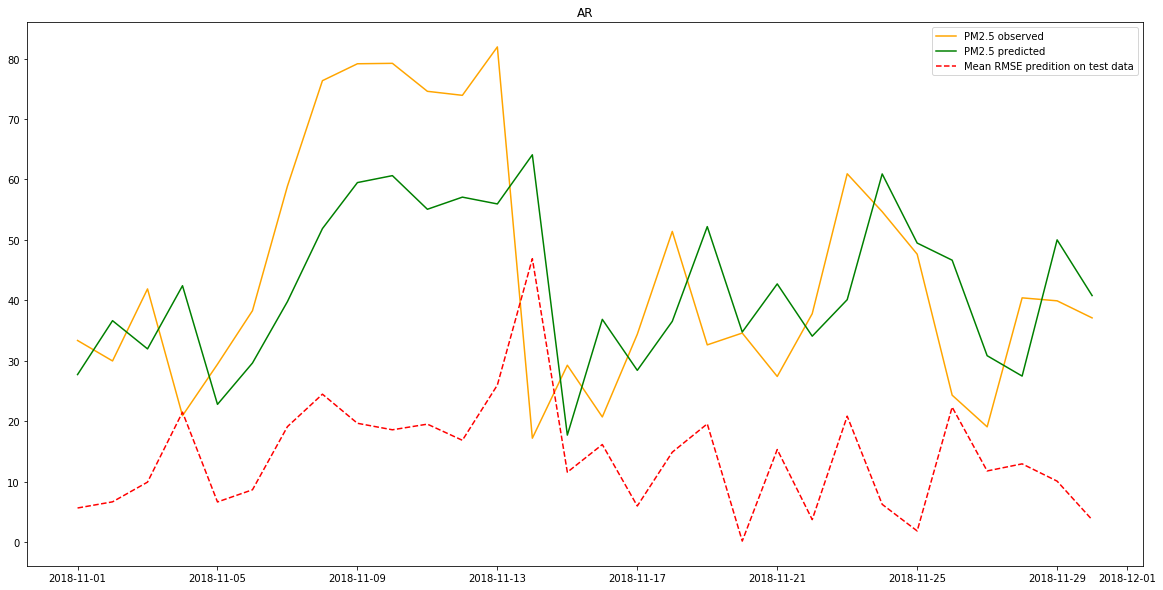

In [147]:
# Zooming
start_date = '2018-11'
end_date = '2018-11-30'

plot_observed_vs_predicted_with_error(observed=observed[start_date:end_date],
                                      predicted=predicted[start_date:end_date],
                                      error=error[start_date:end_date],
                                      num_points=cut_off_offset,
                                      title=model_name,
                                      label_observed='PM2.5 observed',
                                      label_predicted='PM2.5 predicted', 
                                      label_error='Mean RMSE predition on test data',
                                      save_path='images/pm25_obs_vs_pred_365_h_ref_simple_averageXXXREMOVE.png')